In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch

from torcheval.metrics.functional import binary_auprc
from tqdm import tqdm

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDatasetDev
from src.deep_ad.data.dagm_utils import dagm_build_key
from src.deep_ad.eval import load_pretrained, pad_image, cut_margins, compute_diff, compute_heatmap, remove_islands
from src.deep_ad.image import plot_images, create_center_mask
from src.deep_ad.metrics import define_mse_metric, define_rmse_metric, define_psnr_metric
from src.deep_ad.save_manager import SaveManager
from src.deep_ad.transforms import create_test_transform, normalize_to_mean_std

In [2]:
# Load configuration and save manager
config = Config(root_dir="..", config_path="../default_config.yml")
config.content_size = 24
config.stride = 16
save_manager = SaveManager(config)

Load pretrained model


In [3]:
run_name = "13-e_class_10_10_batch_pad_v3"
checkpoint_name = "epoch_600"
model = load_pretrained(config, save_manager, run_name, checkpoint_name)
model = model.to(config.device)

Checkpoint loaded from '..\save\checkpoints\13-e_class_10_10_batch_pad_v3\epoch_600.pt'.


Load the test dataset


In [4]:
test_transform = create_test_transform()
test_dataset = DAGMDatasetDev(
    img_dir=config.DAGM_raw_dir,
    transform=test_transform,
    target_transform=test_transform,
    classes=[10],
    type="Defect-only",
    train=False,
)

Load image(s)


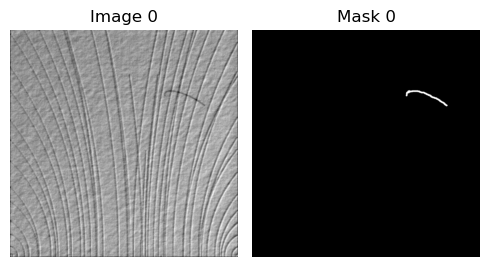

In [5]:
%matplotlib inline
idx = 0
image, image_mask, image_class, image_name = test_dataset[idx]
image_key = dagm_build_key(str(image_class), image_name)
image, image_mask = image.squeeze(), image_mask.squeeze()
titles = [f"Image {idx}", f"Mask {idx}"]
plot_images([image, image_mask], titles, rows=1, cols=2)

Notations:

$$
\begin{align*}
L &:=\text{image size} &=512\\
l &:=\text{patch size} &=128\\
c &:=\text{center size} &=32\\
c' &:=\text{content size} &=24\\
s &:=\text{stride} &=16\\
mp &:=\text{minimum padding} &=52\\
m &:=\text{margin} &=8\\
p &:=\text{total padding} &=60\\
\end{align*}
$$

In order to compute how much padding we need to add to each image, we must take into account several considerations.

In the first place, we want the first patch to have its content region (the center $24\times24$ region) placed on the top-leftmost pixel of the original, unpadded image. Thus, we have a _minimum padding_ ($mp$), which will be the required padding to add for the first patch to be able to reside with their center $24\times24$ regions on the $(0, 0)$ coordinates of the original image:
$$mp = \frac{l - c'}{2}$$

Second, if we slide a $24\times24$ window with stride $16$ over the original image, the last patch might require an additional margin because it won't fit. Let's call this margin $m$:
$$m = (s - ((L - c')\mod s))\mod s$$

Lastly, the total padding required, $p$, will be the sum of the minimum padding and the margin:
$$p=mp+m$$


Minimum required padding: 52
Additional margin: 8
Total padding: 60
Padded image shape: torch.Size([632, 632])
Number of windows: 32


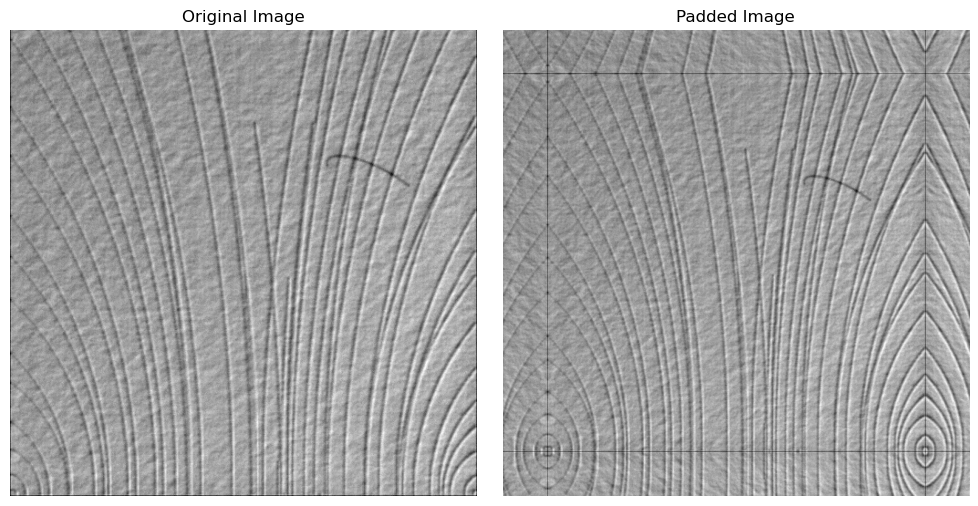

In [6]:
padded_image, min_pad, margin, pad_size = pad_image(config, image.unsqueeze(0))
image_length = image.shape[-1]
num_windows = (image_length + 2 * pad_size - config.patch_size) // config.stride + 1
print(f"Minimum required padding: {min_pad}")
print(f"Additional margin: {margin}")
print(f"Total padding: {pad_size}")
print(f"Padded image shape: {padded_image.shape}")
print(f"Number of windows: {num_windows}")
plot_images([image, padded_image], ["Original Image", "Padded Image"], rows=1, cols=2, figsize=(10, 5))

#### Load inpainted image if possible, otherwise run inference process and save inpainted image

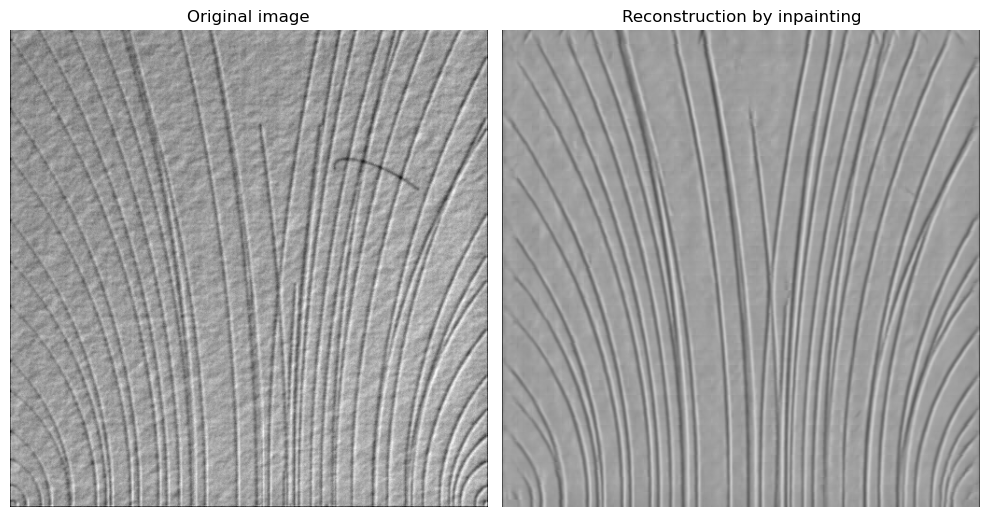

In [7]:
inpainted_image = save_manager.try_load_inpainting(image_key, run_name, checkpoint_name)
if inpainted_image is None:
    print("Inpainted image could not be loaded!")
else:
    plot_images(
        [image, inpainted_image],
        ["Original image", "Reconstruction by inpainting"],
        rows=1,
        cols=2,
        figsize=(10, 10),
    )

Patches processed: 100%|██████████| 1024/1024 [00:08<00:00, 126.90patch/s]


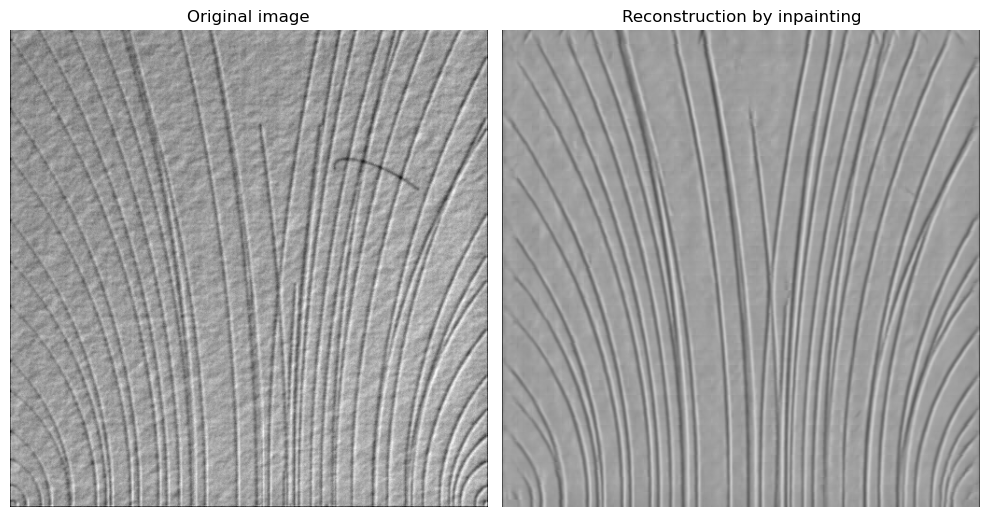

In [8]:
%matplotlib inline
patches = []
inputs = []
outputs = []
titles = []
image_contents = []
inpainted_contents = []
mask = torch.asarray(create_center_mask(image_size=config.patch_size, center_size=config.center_size))
with tqdm(total=num_windows**2, desc="Patches processed", unit="patch") as pbar, torch.no_grad():
    for i in range(num_windows):
        for j in range(num_windows):
            tli, bri = margin + i * config.stride, margin + i * config.stride + config.patch_size  # top-left
            tlj, brj = margin + j * config.stride, margin + j * config.stride + config.patch_size  # bottom-right
            patch = padded_image[tli:bri, tlj:brj]
            # for patch in patches:
            input = normalize_to_mean_std(
                patch.unsqueeze(0).unsqueeze(0), mean=0.5267019737681685, std=0.19957033073362934
            )
            input = input * (1 - mask)
            input = input.to(config.device)
            output = model(input)
            output = normalize_to_mean_std(output, mean=image.mean(), std=image.std())
            tl, br = (config.patch_size - config.content_size) // 2, (config.patch_size + config.content_size) // 2
            image_contents.append(patch[tl:br, tl:br])
            inpainted_contents.append(output.detach().squeeze().cpu().numpy()[tl:br, tl:br])
            outputs.append(output.detach().squeeze().cpu().numpy())
            pbar.update(1)
inpainted_contents = torch.asarray(np.array(inpainted_contents))

diffs = [torch.abs(torch.asarray(input) - torch.asarray(output)) for input, output in zip(inputs, outputs)]
content_mask = create_center_mask(128, 24)
contents = [diff * content_mask for diff in diffs]

image_size = image.shape[-1]
inpainted_image = torch.zeros((image_size + margin, image_size + margin))
weights = torch.zeros((image_size + margin, image_size + margin))
for i in range(num_windows):
    for j in range(num_windows):
        tli, bri = i * config.stride, i * config.stride + config.content_size
        tlj, brj = j * config.stride, j * config.stride + config.content_size
        inpainted_image[tli:bri, tlj:brj] += torch.asarray(inpainted_contents[i * num_windows + j])
        weights[tli:bri, tlj:brj] += 1
inpainted_image /= weights
inpainted_image = inpainted_image[:image_size, :image_size]
plot_images(
    [image, inpainted_image],
    ["Original image", "Reconstruction by inpainting"],
    rows=1,
    cols=2,
    figsize=(10, 10),
)

#### Postprocessing

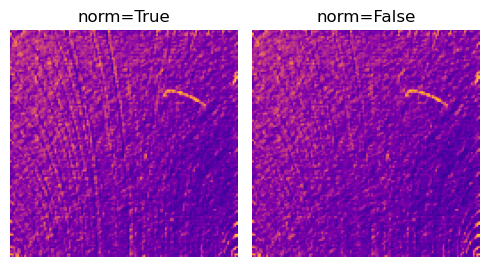

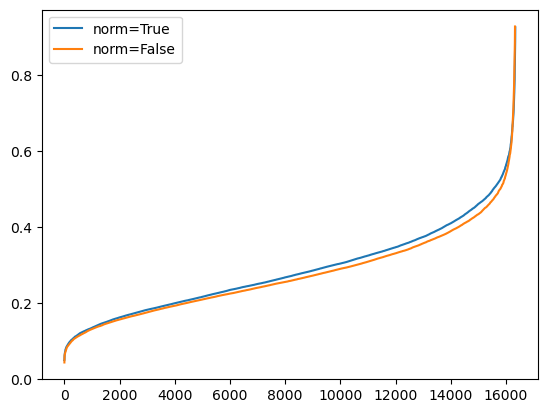

In [9]:
%matplotlib inline

diff_image = compute_diff(image, inpainted_image, norm=False)
hm_num_windows = (diff_image.shape[-1] - config.hm_patch_size) // config.hm_patch_size + 1
# Cut the margins
diff_cut = cut_margins(diff_image.clone(), margin=1)
patch_metric = lambda patch: patch.max()
heatmap = compute_heatmap(diff_cut, config.hm_patch_size, hm_num_windows, patch_metric)

diff_image_norm = compute_diff(image, inpainted_image, norm=True)
diff_cut_norm = cut_margins(diff_image_norm.clone(), margin=1)
heatmap_norm = compute_heatmap(diff_cut_norm, config.hm_patch_size, hm_num_windows, patch_metric)

plot_images([heatmap_norm, heatmap], ["norm=True", "norm=False"], range="01", cmap='plasma', rows=1, cols=2)
plt.plot(torch.unique(torch.sort(heatmap_norm.flatten())[0]), label="norm=True")
plt.plot(torch.unique(torch.sort(heatmap.flatten())[0]), label="norm=False")
plt.legend()
plt.show()

diff_image = diff_image_norm

In [10]:
diff_fl = diff_image.flatten()
top_percent = torch.sort(diff_fl)[0][-int(len(diff_fl) * 0.01):]
print(top_percent)
print(top_percent.mean())

tensor([0.5120, 0.5120, 0.5121,  ..., 0.9845, 0.9961, 1.0000])
tensor(0.6864)


In [11]:
%matplotlib inline
diff_fl = diff_image.flatten()
max_threshold = torch.mean(torch.sort(diff_fl)[0][-int(len(diff_fl) * 0.01):])
thresholds = np.arange(max(0, max_threshold - 0.3), max_threshold, 0.001)
auprcs = []
all_island_sizes = []
for threshold in tqdm(thresholds):
    hmc = heatmap.clone()
    hmc[hmc < threshold] = 0
    hmc[hmc >= threshold] = 1
    hmc, island_sizes = remove_islands(hmc)
    all_island_sizes.append(island_sizes)
    auprcs.append(binary_auprc((diff_image * hmc).reshape(-1), image_mask.reshape(-1)).item())

100%|██████████| 300/300 [00:02<00:00, 102.63it/s]


AUPRC>=0.5: 0.427-0.590
AUPRC>=0.55: 0.427-0.590
AUPRC>=0.6: 0.454-0.590
AUPRC>=0.65: 0.483-0.590
AUPRC>=0.7: 0.483-0.563
AUPRC>=0.75: 0.483-0.563
AUPRC>=0.8: 0.483-0.563
AUPRC>=0.8309752941131592: 0.483-0.500


Text(0, 0.5, 'AUPRC')

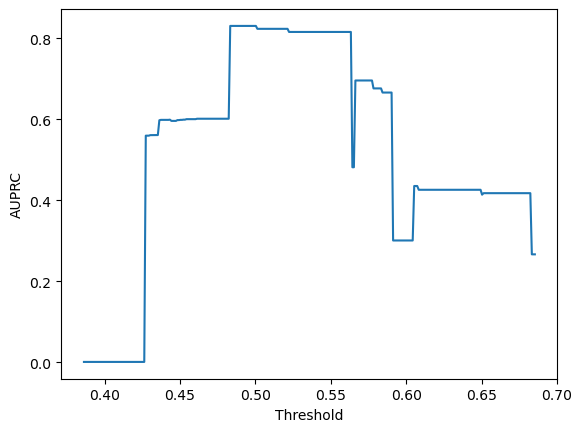

In [12]:
%matplotlib inline
auprcs = np.array(auprcs)
for auprc_threshold in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, max(auprcs)]:
    auprc_thresholds = thresholds[auprcs >= auprc_threshold]
    if len(auprc_thresholds) == 0:
        auprc_thresholds = [float("nan")]
    print(f"AUPRC>={auprc_threshold}: {auprc_thresholds[0]:.3f}-{auprc_thresholds[-1]:.3f}")
plt.plot(thresholds, auprcs)
plt.xlabel("Threshold")
plt.ylabel("AUPRC")

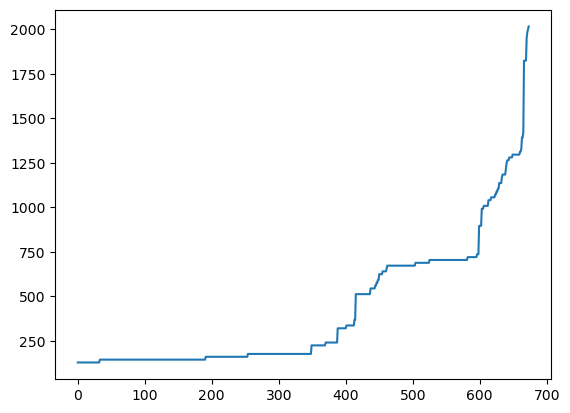

median_size: 176
lower: 123.19999999999999, upper: 228.8
Island lengths in [lower, upper]: 370/674
Number of thresholds with islands in [lower, upper]: 102/300
Good thresholds lie in range [0.584-0.685]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [13]:
%matplotlib inline
def flatten(xs):
    return [x for ys in xs for x in ys]
all_fl = np.sort(np.array(flatten(all_island_sizes)))
plt.plot(all_fl)
plt.show()
err = 30 / 100
median_size = all_fl[len(all_fl) // 2]
print(f"median_size: {median_size}")
lower = median_size * (1 - err)
upper = median_size * (1 + err)
print(f"lower: {lower}, upper: {upper}")
print(f"Island lengths in [lower, upper]: {np.sum(np.logical_and(all_fl >= lower, all_fl <= upper))}/{len(all_fl)}")
good_thresholds_mask = [any(lower <= size <= upper for size in sublist) for sublist in all_island_sizes]
print(f"Number of thresholds with islands in [lower, upper]: {sum(good_thresholds_mask)}/{len(all_island_sizes)}")
good_thresholds = thresholds[good_thresholds_mask]
print(f"Good thresholds lie in range [{good_thresholds[0]:.3f}-{good_thresholds[-1]:.3f}]")
good_thresholds_mask2 = [good and len(sublist) == 1 for good, sublist in zip(good_thresholds_mask, all_island_sizes)]
good_thresholds2 = thresholds[good_thresholds_mask2]
good_island_sizes2 = np.array([sublist for good, sublist in zip(good_thresholds_mask2, all_island_sizes) if good]).flatten()
print(f"Good thresholds 2 lie in range [{good_thresholds2[0]:.3f}-{good_thresholds2[-1]:.3f}]")
best_threshold = np.median(good_thresholds2)

hmc = heatmap.clone()
hmc[hmc < best_threshold] = 0
hmc[hmc >= best_threshold] = 1
hmc, _ = remove_islands(hmc)
best_auprc = binary_auprc((diff_image * hmc).reshape(-1), image_mask.reshape(-1)).item()
print(f"best_threshold: {best_threshold}")
print(f"corresponding AUPRC: {best_auprc}")
plt.plot(good_thresholds2, good_island_sizes2)

In [382]:
%matplotlib tk
from matplotlib.widgets import Slider


def apply_transforms(image: torch.Tensor, threshold: float, width: int) -> torch.Tensor:
    hmc = heatmap.clone()
    hmc[hmc < threshold] = 0
    hmc[hmc >= threshold] = 1
    hmc, _ = remove_islands(hmc)
    if width > 0:
        image[:width, :] = 0
        image[-width:, :] = 0
        image[:, :width] = 0
        image[:, -width:] = 0
    image = image * hmc
    return image

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(bottom=0.25)

threshold = 0.625
slider_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])
slider_threshold = Slider(slider_ax, "Threshold", 0, 1, valinit=threshold, valstep=0.001)

width = 0
slider_width = Slider(fig.add_axes([0.2, 0.15, 0.6, 0.03]), "Width", 0, 100, valinit=width, valstep=1)

initial_image = apply_transforms(diff_image.clone(), threshold, width)
im = axs.imshow(initial_image, vmin=0, vmax=1, cmap='gray')
im_title = fig.suptitle(f"AUPRC: {binary_auprc(initial_image.reshape(-1), image_mask.reshape(-1))}")

def update_plot(new_image: torch.Tensor) -> None:
    global im, im_title, fig
    im.set_data(new_image)
    im_title.set_text(f"AUPRC: {binary_auprc(new_image.reshape(-1), image_mask.reshape(-1))}")
    fig.canvas.draw_idle()

def update_threshold(val: float) -> None:
    global threshold, width
    threshold = val
    diff_thresholded = apply_transforms(diff_image.clone(), threshold, width)
    update_plot(diff_thresholded)

def update_width(val: float) -> None:
    global width
    width = int(val)
    diff_thresholded = apply_transforms(diff_image.clone(), threshold, width)
    update_plot(diff_thresholded)

slider_threshold.on_changed(update_threshold)
slider_width.on_changed(update_width)
plt.show()

NameError: name 'diff_patches' is not defined

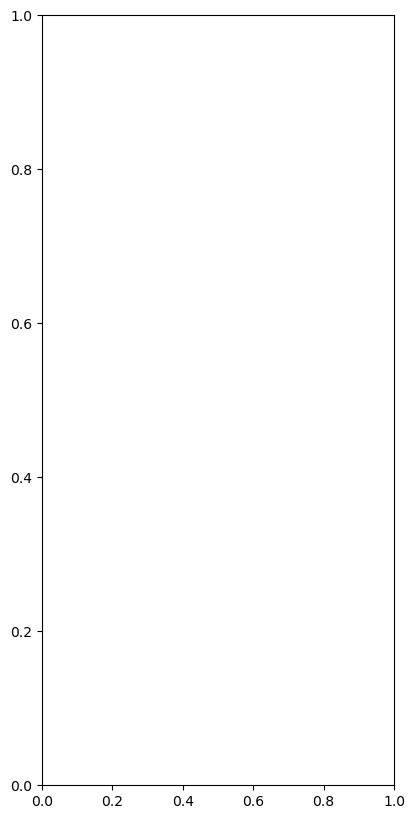

In [13]:
%matplotlib inline
import matplotlib.patches as mpl_patches

sw_stride = 8
sw_size = 8
sw_num_windows = (diff_image.shape[-1] - sw_size) // sw_stride + 1

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
row, col = 19, 50
plt.imshow(diff_patches[row * sw_num_windows + col], vmin=0, vmax=1, cmap="plasma")

ax = plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(diff_image.numpy(), cv.COLOR_GRAY2RGB))
rect = mpl_patches.Rectangle((col * sw_stride, row * sw_stride), sw_size, sw_size, facecolor='red', edgecolor='red', alpha=1)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [20]:
mse_metric = define_mse_metric()
mse = mse_metric(image, inpainted_image)
print(f"MSE: {mse}")
my_mse = torch.sum((image - inpainted_image) ** 2) / (image.shape[-1] * image.shape[-2])
print(f"My MSE: {my_mse}")
print(f"MSE == My MSE?: {mse == my_mse}")

rmse_metric = define_rmse_metric()
rmse = rmse_metric(image, inpainted_image)
print(f"RMSE: {rmse}")
my_rmse = torch.sqrt(my_mse)
print(f"My RMSE: {my_rmse}")
print(f"RMSE == My RMSE?: {rmse == my_rmse}")

psnr_metric = define_psnr_metric()
psnr = psnr_metric(inpainted_image, image)
print(f"PSNR: {psnr}")
my_psnr = 20 * torch.log10(torch.max(image)) - 10 * torch.log10(my_mse)
print(f"My PSNR: {my_psnr}")
print(f"PSNR ==(close) My PSNR?: {torch.allclose(psnr, my_psnr)}")

MSE: 0.005090771708637476
My MSE: 0.005090771708637476
MSE == My MSE?: True
RMSE: 0.07134964317083359
My RMSE: 0.07134964317083359
RMSE == My RMSE?: True
PSNR: 22.898035049438477
My PSNR: 22.89803695678711
PSNR ==(close) My PSNR?: True
